# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

### 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('/Users/lakshyadujari/Desktop/Projects/NIC_AI/FaceDetection/data')
PROJ_PATH = os.path.join('/Users/lakshyadujari/Desktop/Projects/NIC_AI/FaceDetection')
number_images = 30

In [158]:
cap = cv2.VideoCapture(1)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,'images',f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(1)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [159]:
!labelme

2024-02-13 14:29:47,114 [INFO   ] __init__:get_config:67- Loading config file from: /Users/lakshyadujari/.labelmerc


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [3]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Load Image into TF Data Pipeline

In [6]:
images = tf.data.Dataset.list_files('/Users/lakshyadujari/Desktop/Projects/NIC_AI/FaceDetection/data/images/*.jpg')

2024-02-15 08:17:09.512172: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-02-15 08:17:09.512203: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-15 08:17:09.512211: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-15 08:17:09.512467: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-15 08:17:09.512862: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
images.as_numpy_iterator().next()

b'/Users/lakshyadujari/Desktop/Projects/NIC_AI/FaceDetection/data/images/03aa7566-ca4d-11ee-a8d8-4e849f2d6e9c.jpg'

In [8]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [9]:
images = images.map(load_image)

In [10]:
images.as_numpy_iterator().next()

array([[[ 65,  75,  85],
        [ 66,  76,  86],
        [ 66,  76,  86],
        ...,
        [ 93,  91,  96],
        [ 92,  90,  95],
        [ 90,  88,  93]],

       [[ 65,  75,  85],
        [ 66,  76,  86],
        [ 66,  76,  86],
        ...,
        [ 94,  92,  97],
        [ 94,  92,  97],
        [ 93,  91,  96]],

       [[ 65,  75,  85],
        [ 66,  76,  86],
        [ 66,  76,  86],
        ...,
        [ 96,  94,  97],
        [ 95,  93,  96],
        [ 95,  93,  96]],

       ...,

       [[ 87,  95,  97],
        [ 87,  95,  97],
        [ 87,  95,  97],
        ...,
        [207, 180, 161],
        [206, 179, 160],
        [205, 178, 159]],

       [[ 87,  95,  97],
        [ 87,  95,  97],
        [ 86,  94,  96],
        ...,
        [207, 180, 161],
        [206, 179, 160],
        [205, 178, 159]],

       [[ 87,  95,  97],
        [ 87,  95,  97],
        [ 86,  94,  96],
        ...,
        [207, 180, 161],
        [206, 179, 160],
        [205, 178, 159]]

In [11]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [12]:
image_generator = images.batch(4).as_numpy_iterator()

In [13]:
plot_images = image_generator.next()

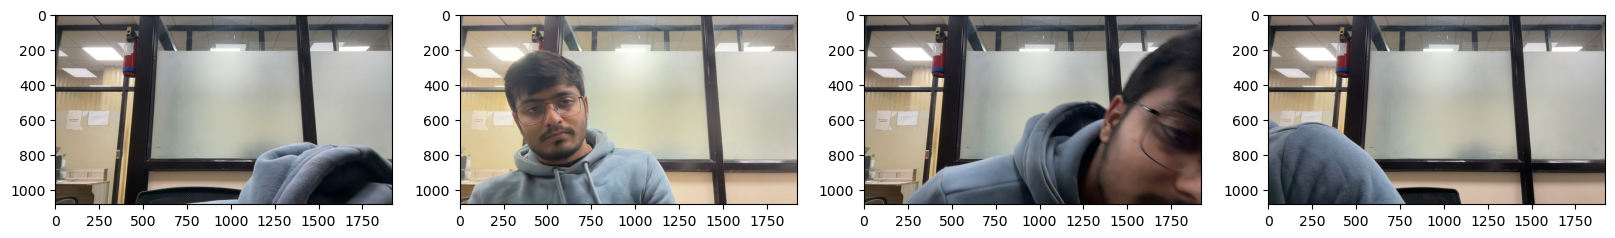

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [15]:
90*.7 # 63 to train

62.99999999999999

In [16]:
90*.15 # 14 and 13 to test and val

13.5

In [17]:
63+13+14

90

In [184]:
# import shutil
# folder = ['train','val','test']
# train_count = 63
# val_count = 14
# folder_count = 0
# count = 0
# for image in os.listdir(os.path.join(IMAGES_PATH, 'images')):
#     source_file = os.path.join(IMAGES_PATH, 'images',image)
#     if count < train_count:
#         folder_count = 0
#     elif count >= train_count and count < train_count+val_count:
#         folder_count = 1
#     else:
#         folder_count = 2
#     destination_folder = os.path.join(IMAGES_PATH,folder[folder_count],'images')
#     shutil.copyfile(source_file, os.path.join(destination_folder,image))
#     count += 1


### 3.2 Move the Matching Labels

In [185]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join(PROJ_PATH,'data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [18]:
import albumentations as alb

In [19]:
augmentor = alb.Compose([alb.RandomCrop(width=620, height=620), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [20]:
img = cv2.imread(os.path.join(IMAGES_PATH,'train','images', '0aacd002-ca4d-11ee-a8d8-4e849f2d6e9c.jpg'))

In [21]:
with open(os.path.join(IMAGES_PATH, 'train', 'labels', '0aacd002-ca4d-11ee-a8d8-4e849f2d6e9c.json'), 'r') as f:
    label = json.load(f)

In [22]:
label

{'version': '5.4.1',
 'flags': {},
 'shapes': [{'label': 'Lakshya',
   'points': [[713.125, 258.125], [1074.375, 743.125]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {},
   'mask': None}],
 'imagePath': '../images/0aacd002-ca4d-11ee-a8d8-4e849f2d6e9c.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQgJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAQ4B4ADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU

In [23]:
label['shapes'][0]['points']

[[713.125, 258.125], [1074.375, 743.125]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [24]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [25]:
coords

[713.125, 258.125, 1074.375, 743.125]

In [26]:
coords = list(np.divide(coords, [1920,1080,1920,1080]))

In [27]:
coords

[0.3714192708333333, 0.23900462962962962, 0.5595703125, 0.6880787037037037]

### 4.4 Apply Augmentations and View Results

In [28]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['Lakshya'])

In [29]:
augmented['bboxes'][0][2:]

(1.0, 0.9163306451612904)

In [30]:
augmented['bboxes']

[(0.9058467741935484, 0.13407258064516128, 1.0, 0.9163306451612904)]

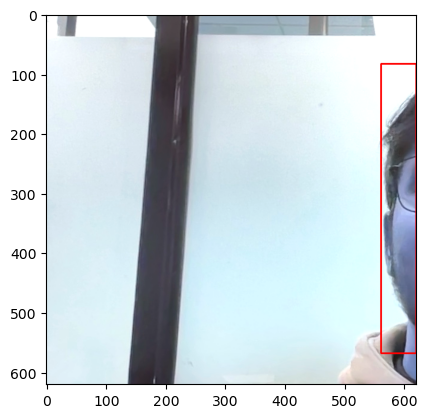

In [31]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [620,620]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [620,620]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [219]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join(IMAGES_PATH, partition, 'images')):
        img = cv2.imread(os.path.join(IMAGES_PATH, partition, 'images', image))
        # print(os.path.join(IMAGES_PATH, partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join(IMAGES_PATH, partition, 'Labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1920,1080,1920,1080]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['Lakshya'])
                cv2.imwrite(os.path.join(PROJ_PATH,'aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                # print(os.path.join(PROJ_PATH,'aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'))
                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join(PROJ_PATH,'aug_data', partition, 'Labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.038736979166666664, 0.9982638888888888, 0.0009765625, 0.3605324074074074, 'Lakshya'].
x_max is less than or equal to x_min for bbox [0.11490885416666667, 0.6730324074074074, 0.0003255208333333333, 0.043402777777777776, 'Lakshya'].


### 5.2 Load Augmented Images to Tensorflow Dataset

In [32]:
train_images = tf.data.Dataset.list_files('/Users/lakshyadujari/Desktop/Projects/NIC_AI/FaceDetection/aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [33]:
test_images = tf.data.Dataset.list_files('/Users/lakshyadujari/Desktop/Projects/NIC_AI/FaceDetection/aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [34]:
val_images = tf.data.Dataset.list_files('/Users/lakshyadujari/Desktop/Projects/NIC_AI/FaceDetection/aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [35]:
train_images.as_numpy_iterator().next().shape

(120, 120, 3)

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [36]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [37]:
train_labels = tf.data.Dataset.list_files('/Users/lakshyadujari/Desktop/Projects/NIC_AI/FaceDetection/aug_data/train/Labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [38]:
test_labels = tf.data.Dataset.list_files('/Users/lakshyadujari/Desktop/Projects/NIC_AI/FaceDetection/aug_data/test/Labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [39]:
val_labels = tf.data.Dataset.list_files('/Users/lakshyadujari/Desktop/Projects/NIC_AI/FaceDetection/aug_data/val/Labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [40]:
train_labels

<_MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.float16, name=None))>

In [41]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.4607, 0.3042, 1.    , 1.    ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [42]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3660, 3660, 780, 780, 840, 840)

### 7.2 Create Final Datasets (Images/Labels)

In [43]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [44]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1500)
test = test.batch(8)
test = test.prefetch(4)

In [45]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(2000)
val = val.batch(8)
val = val.prefetch(4)

### 7.3 View Images and Annotations

In [46]:
data_samples = train.as_numpy_iterator()

In [47]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


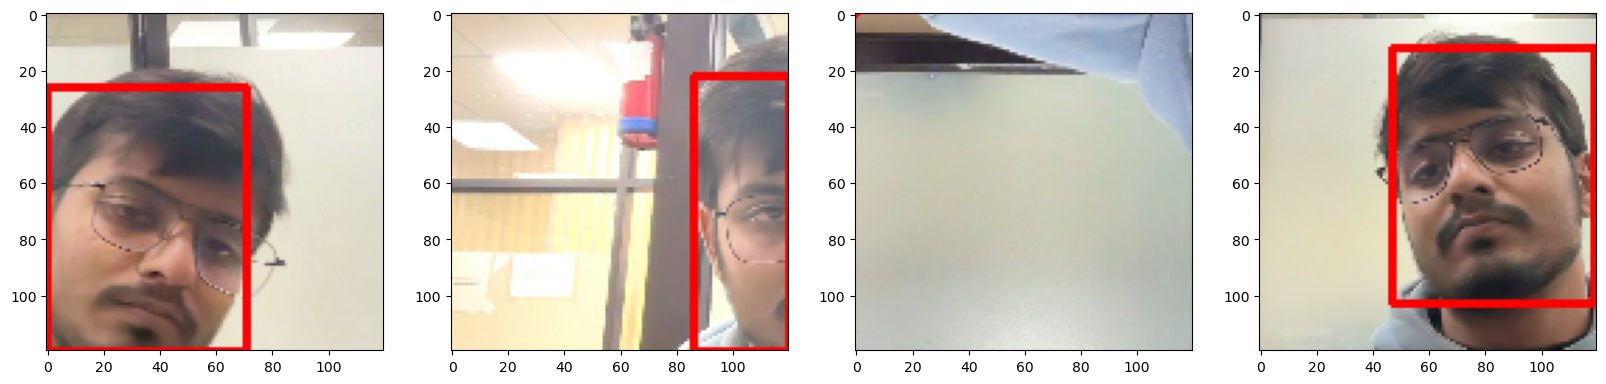

In [48]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    coppy = sample_image.copy()
    cv2.rectangle(coppy, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(coppy)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [172]:
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [173]:
vgg = VGG16(include_top=False)

In [174]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [175]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [176]:
facetracker = build_model()

In [177]:
facetracker.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_9[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d_4 (Gl  (None, 512)                  0         ['vgg16[0][0]']               
 obalMaxPooling2D)                                                                                
                                                                                            

In [178]:
X,y = train.as_numpy_iterator().next()

In [179]:
y

(array([[1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.      , 0.0667  , 0.6626  , 0.956   ],
        [0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.02963 , 0.5874  ],
        [0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      ],
        [0.565   , 0.011086, 1.      , 1.      ],
        [0.5474  , 0.      , 1.      , 0.6045  ],
        [0.      , 0.      , 0.      , 0.      ]], dtype=float16))

In [180]:
print(X)


[[[[0.24000545 0.18899782 0.25566447]
   [0.4472222  0.37957516 0.44232026]
   [0.50177014 0.43510348 0.5056917 ]
   ...
   [0.8886982  0.74752176 0.60634524]
   [0.8960784  0.74607843 0.6156863 ]
   [0.9019608  0.7490196  0.61960787]]

  [[0.46429738 0.40645427 0.4750817 ]
   [0.5019608  0.43529412 0.5058824 ]
   [0.5004902  0.43382353 0.50539213]
   ...
   [0.89272875 0.74959147 0.608415  ]
   [0.89485294 0.7470588  0.6159314 ]
   [0.89436287 0.7531864  0.6198531 ]]

  [[0.49196622 0.42529956 0.49980935]
   [0.5010621  0.43635622 0.510866  ]
   [0.5107843  0.45196074 0.5264706 ]
   ...
   [0.9003268  0.7513072  0.6101307 ]
   [0.89436275 0.7443628  0.6139706 ]
   [0.89379066 0.7526142  0.6192809 ]]

  ...

  [[0.996269   0.95313174 0.9845043 ]
   [0.9970588  0.95392156 0.9852941 ]
   [0.9990468  0.9559095  0.97943896]
   ...
   [1.         0.95686275 0.9882353 ]
   [1.         0.95686275 0.9882353 ]
   [1.         0.95686275 0.9882353 ]]

  [[1.         0.95686275 0.9882353 ]
   [1. 

In [181]:
print(X.shape)


(8, 120, 120, 3)


In [182]:
print(y)


(array([[1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0]], dtype=uint8), array([[0.      , 0.0667  , 0.6626  , 0.956   ],
       [0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.02963 , 0.5874  ],
       [0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      ],
       [0.565   , 0.011086, 1.      , 1.      ],
       [0.5474  , 0.      , 1.      , 0.6045  ],
       [0.      , 0.      , 0.      , 0.      ]], dtype=float16))


In [183]:
for y_item in y:
    print(y_item.shape)

(8, 1)
(8, 4)


In [184]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 233ms/step


In [185]:
print(classes)
print(coords)

[[0.40347838]
 [0.40718853]
 [0.4242852 ]
 [0.4171859 ]
 [0.41164112]
 [0.51421213]
 [0.45770398]
 [0.44067016]]
[[0.9034788  0.26708895 0.33338216 0.522956  ]
 [0.76259136 0.42302176 0.2059271  0.36619157]
 [0.8436204  0.32762972 0.4000119  0.44552234]
 [0.81618863 0.44322062 0.34388915 0.3945138 ]
 [0.8089908  0.2925466  0.21675976 0.370634  ]
 [0.8868666  0.40194348 0.40283972 0.43326336]
 [0.9139546  0.39569935 0.30937347 0.46808952]
 [0.8349272  0.33401287 0.24287061 0.3850921 ]]


# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [186]:
-.25/218

-0.0011467889908256881

In [187]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1) / batches_per_epoch

In [188]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)

### 9.2 Create Localization Loss and Classification Loss

In [189]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [190]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [191]:
localization_loss(y[1], tf.cast(coords,tf.float16))

<tf.Tensor: shape=(), dtype=float16, numpy=12.17>

In [192]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.673229>

In [193]:
regressloss(y[1], tf.cast(coords,tf.float16))

<tf.Tensor: shape=(), dtype=float16, numpy=12.17>

# 10. Train Neural Network

In [379]:
tf.config.run_functions_eagerly(False)

### 10.1 Create Custom Model Class

In [194]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
        
    def train_step(self, batch, **kwargs): 
        
        X_in, y_in = batch
        # X_in, y_in = train.as_numpy_iterator().next()
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X_in, training=True)
            batch_classloss = self.closs(y_in[0],classes)
            batch_localizationloss = self.lloss(tf.cast(y_in[1],tf.float32),tf.cast(coords,tf.float32))
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    def test_step(self, batch, **kwargs): 
        X_in, y_in = batch
        classes, coords = self.model(X_in, training=False)
        batch_classloss = self.closs(y_in[0],classes)
        batch_localizationloss = self.lloss(tf.cast(y_in[1],tf.float32),tf.cast(coords,tf.float32))
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [195]:
model = FaceTracker(facetracker)

In [196]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [197]:
logdir='/Users/lakshyadujari/Desktop/Projects/NIC_AI/FaceDetection/logs'

In [198]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [199]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='total_loss', patience=2, restore_best_weights=True)
optimizers = ['Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD']
hist_trace = []
for i in optimizers:
    print('Model with Optimizer as', i)
    model.compile(i, classloss, regressloss)
    hist_trace.append(model.fit(train, epochs=10, validation_data=val, callbacks=[early_stopping]))

Model with Optimizer as Adadelta
Epoch 1/10
458/458 [==============================] - 42s 80ms/step - total_loss: 0.9818 - class_loss: 0.2267 - regress_loss: 0.8684 - val_total_loss: 0.0239 - val_class_loss: 0.0035 - val_regress_loss: 0.0221
Epoch 2/10
458/458 [==============================] - 40s 79ms/step - total_loss: 0.5375 - class_loss: 0.1228 - regress_loss: 0.4761 - val_total_loss: 1.3220 - val_class_loss: 0.5104 - val_regress_loss: 1.0668
Epoch 3/10
458/458 [==============================] - 41s 81ms/step - total_loss: 0.6276 - class_loss: 0.1522 - regress_loss: 0.5515 - val_total_loss: 0.4783 - val_class_loss: 0.0171 - val_regress_loss: 0.4698
Model with Optimizer as Adagrad
Epoch 1/10
458/458 [==============================] - 45s 86ms/step - total_loss: 0.5877 - class_loss: 0.1330 - regress_loss: 0.5212 - val_total_loss: 0.2351 - val_class_loss: 0.1212 - val_regress_loss: 0.1745
Epoch 2/10
458/458 [==============================] - 41s 80ms/step - total_loss: 0.4923 - clas

### 10.3 Plot Performance

Loss with Adadelta optimizer


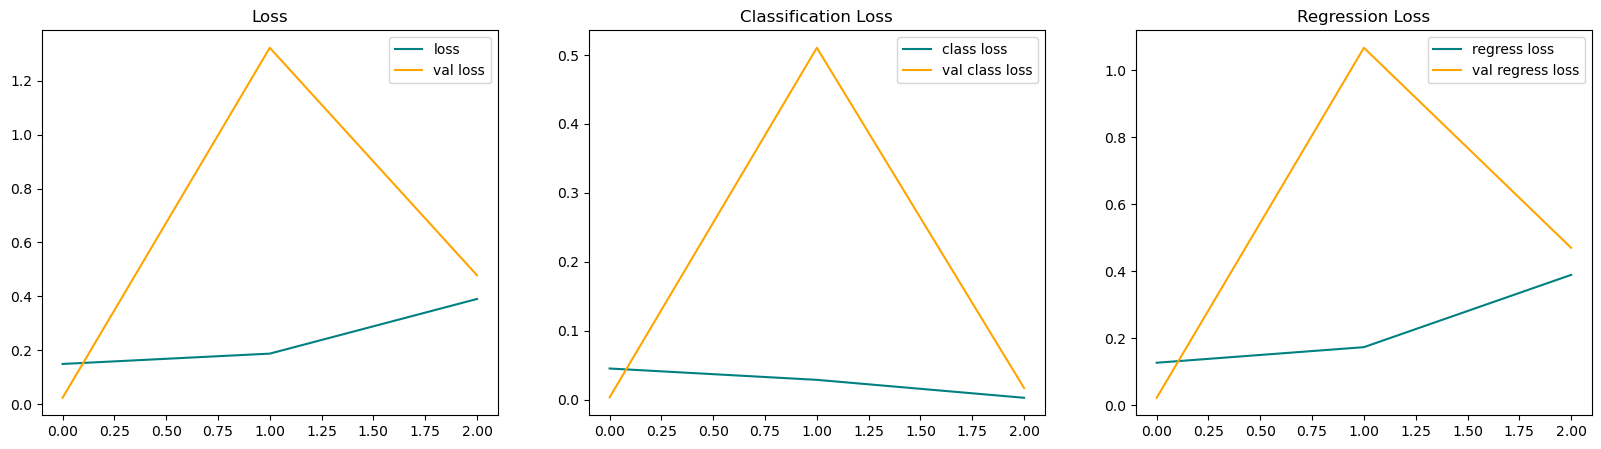

Loss with Adagrad optimizer


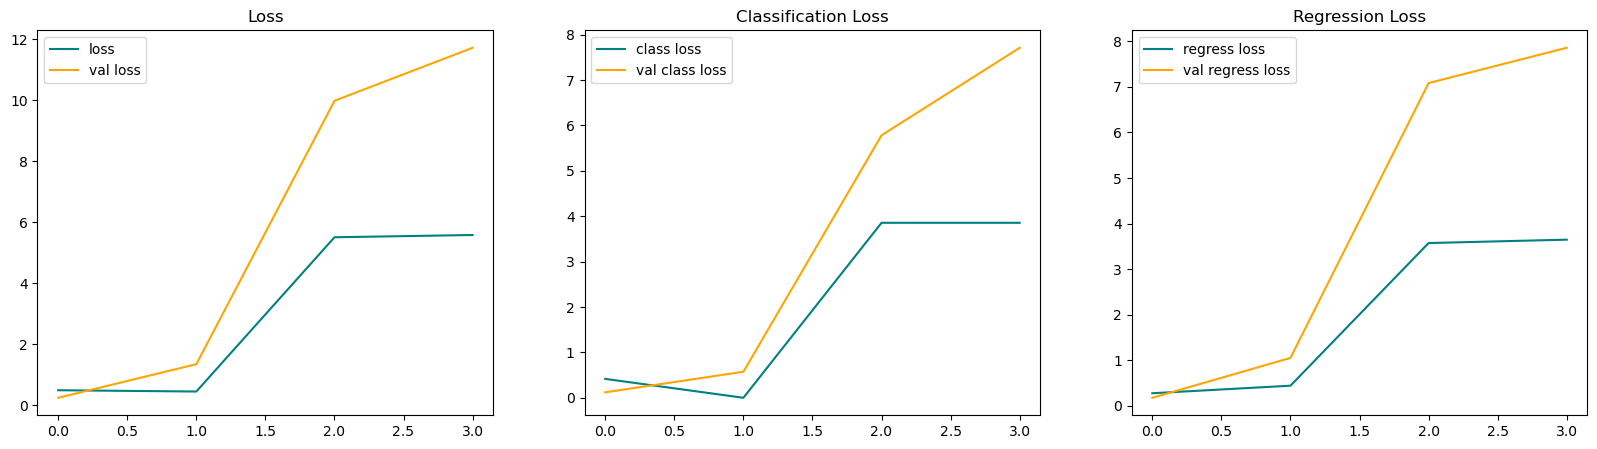

Loss with Adam optimizer


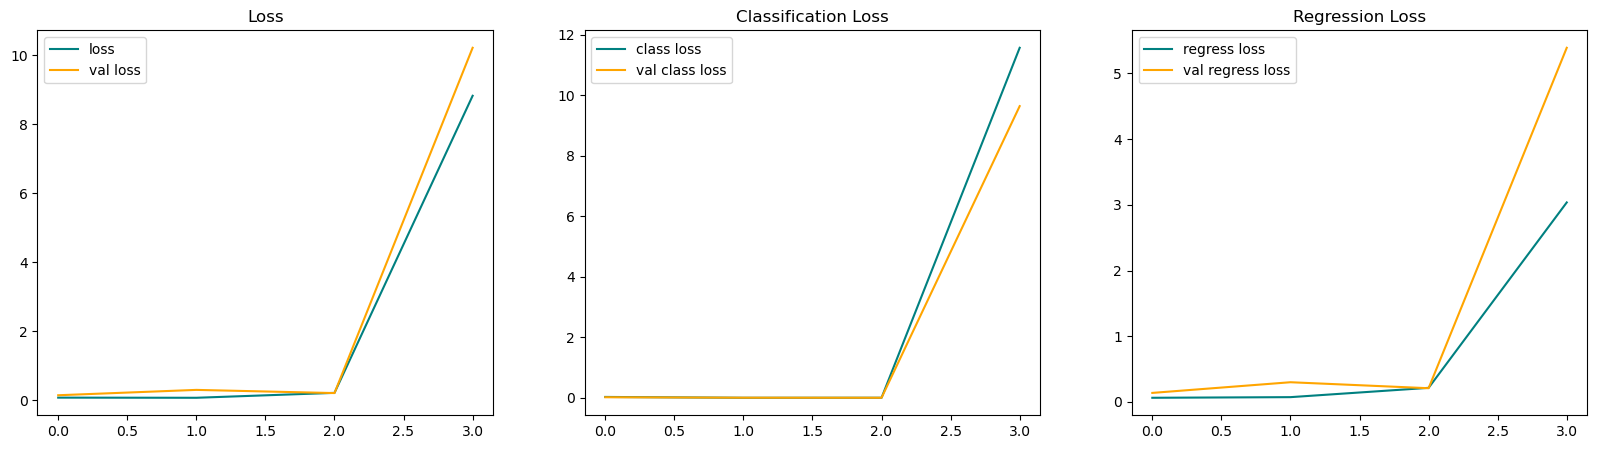

Loss with RMSprop optimizer


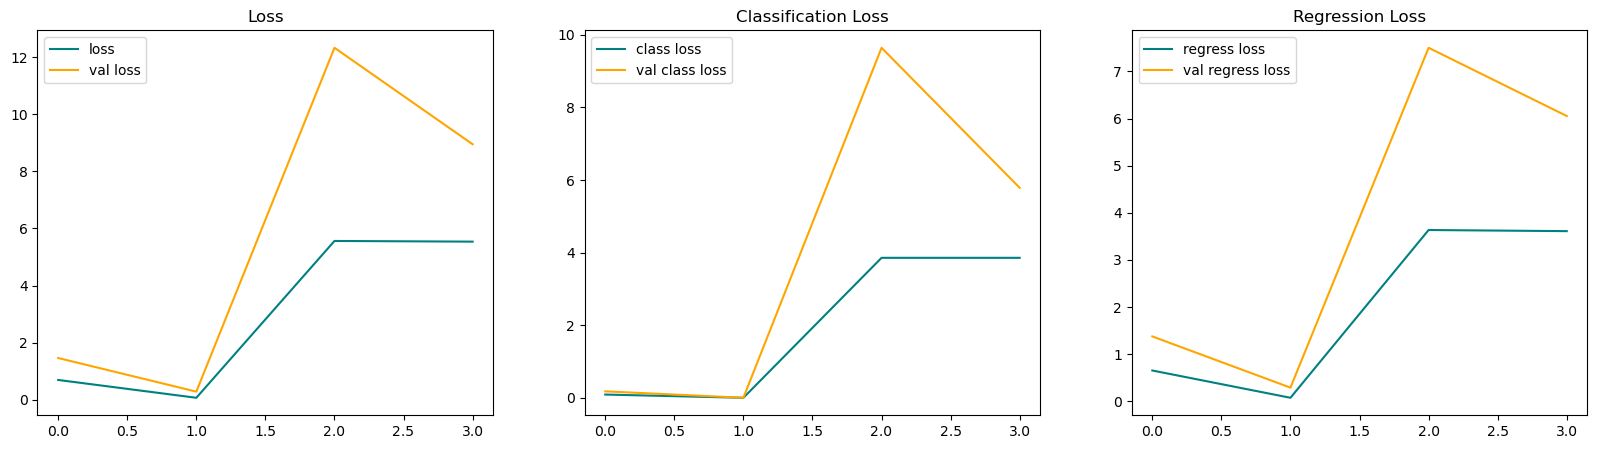

Loss with SGD optimizer


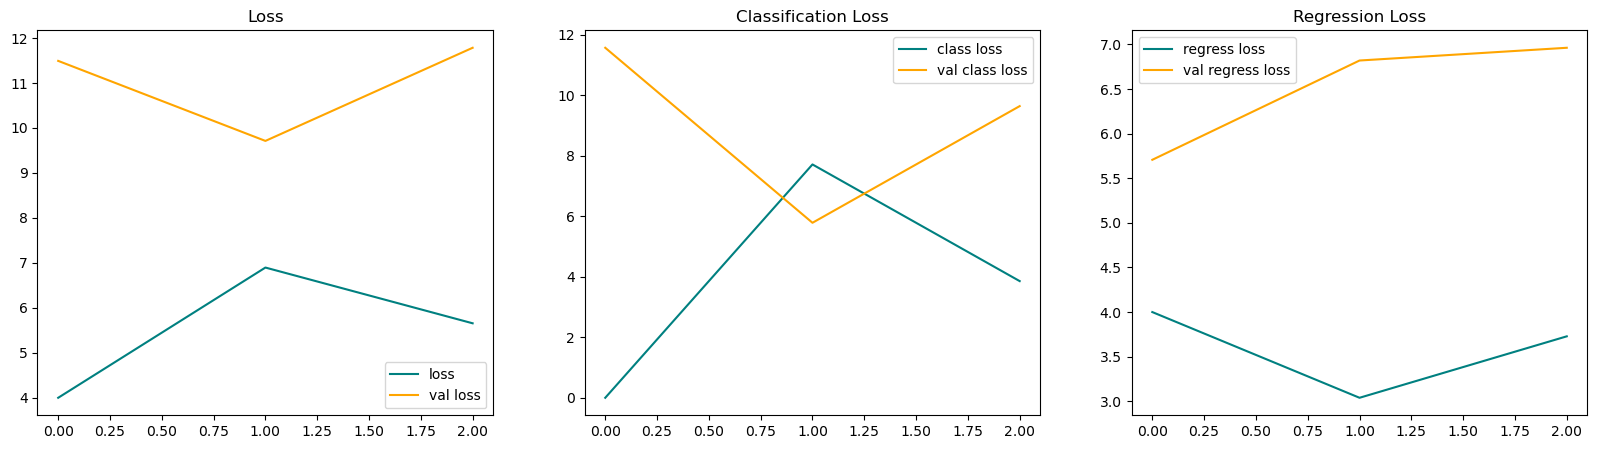

In [204]:
count = 0
for hist in hist_trace:
    fig, ax = plt.subplots(ncols=3, figsize=(20,5))
    print('Loss with '+ optimizers[count]+' optimizer' )
    ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
    ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
    ax[0].title.set_text('Loss')
    ax[0].legend()

    ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
    ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
    ax[1].title.set_text('Classification Loss')
    ax[1].legend()

    ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
    ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
    ax[2].title.set_text('Regression Loss')
    ax[2].legend()
    count += 1
    plt.show()

In [205]:
# delete the previous model first
del vgg
del facetracker
del model
vgg = VGG16(include_top=False)
facetracker = build_model()
model = FaceTracker(facetracker)
model.compile(opt, classloss, regressloss)

In [206]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='total_loss', patience=2, restore_best_weights=True)
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[early_stopping])

Epoch 1/10
458/458 [==============================] - 44s 83ms/step - total_loss: 2.7678 - class_loss: 0.7012 - regress_loss: 2.4172 - val_total_loss: 2.9257 - val_class_loss: 0.6927 - val_regress_loss: 2.5794
Epoch 2/10
458/458 [==============================] - 39s 76ms/step - total_loss: 2.1546 - class_loss: 0.5618 - regress_loss: 1.8737 - val_total_loss: 2.3643 - val_class_loss: 0.4426 - val_regress_loss: 2.1430
Epoch 3/10
458/458 [==============================] - 39s 77ms/step - total_loss: 0.9888 - class_loss: 0.2711 - regress_loss: 0.8533 - val_total_loss: 1.6195 - val_class_loss: 0.3760 - val_regress_loss: 1.4315
Epoch 4/10
458/458 [==============================] - 39s 77ms/step - total_loss: 0.8051 - class_loss: 0.2219 - regress_loss: 0.6942 - val_total_loss: 1.0012 - val_class_loss: 0.4416 - val_regress_loss: 0.7804
Epoch 5/10
458/458 [==============================] - 39s 77ms/step - total_loss: 0.7190 - class_loss: 0.1903 - regress_loss: 0.6239 - val_total_loss: 2.1659 - 

In [207]:
hist.history

{'total_loss': [1.2949061393737793,
  0.3723405599594116,
  0.1500970721244812,
  0.11238576471805573,
  1.1374828815460205,
  2.4006760120391846],
 'class_loss': [0.6956775188446045,
  0.011980862356722355,
  0.05827898532152176,
  0.03631460294127464,
  0.5888886451721191,
  1.9978011846542358],
 'regress_loss': [0.947067379951477,
  0.36635011434555054,
  0.12095758318901062,
  0.09422846138477325,
  0.8430386185646057,
  1.4017753601074219],
 'val_total_loss': [2.9257209300994873,
  2.3642728328704834,
  1.619512677192688,
  1.0012089014053345,
  2.1658997535705566,
  0.3776031732559204],
 'val_class_loss': [0.6927057504653931,
  0.4426027536392212,
  0.3760477900505066,
  0.44162502884864807,
  0.8642604351043701,
  0.4162508249282837],
 'val_regress_loss': [2.5793681144714355,
  2.1429715156555176,
  1.4314887523651123,
  0.7803963422775269,
  1.733769416809082,
  0.16947776079177856]}

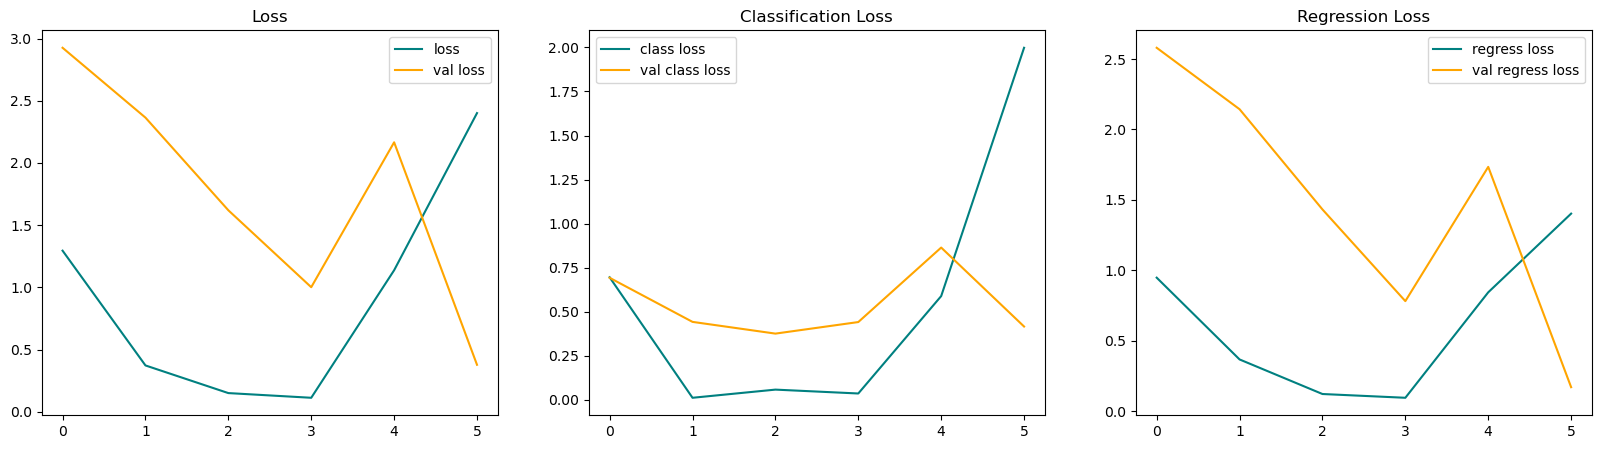

In [208]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()
plt.show()

# Resnet Modal

In [230]:

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

from tensorflow.keras.applications.resnet import ResNet50

def build_model2(): 
    # input_layer = Input(shape=(224,224,3))
    # Load pre-trained ResNet50 model without the top layer
    resnet_model = ResNet50(
        weights='imagenet',
        input_shape=(224,224,3),
        include_top=False
    )
    resnet_model.trainable = False
    # Classification Model  
    f1 = GlobalMaxPooling2D()(resnet_model.output)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # # Bounding box model
    # f2 = GlobalMaxPooling2D()(resnet_model.output)
    # regress1 = Dense(2048, activation='relu')(f2)
    # regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker2 = Model(inputs=resnet_model.input, outputs=[class2])
    return facetracker2


In [231]:
facetracker2 = build_model2()

In [232]:
facetracker2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_14[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [233]:
train_images = tf.data.Dataset.list_files('/Users/lakshyadujari/Desktop/Projects/NIC_AI/FaceDetection/aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (224,224)))
train_images = train_images.map(lambda x: x/255)

In [234]:
test_images = tf.data.Dataset.list_files('/Users/lakshyadujari/Desktop/Projects/NIC_AI/FaceDetection/aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (224,224)))
test_images = test_images.map(lambda x: x/255)

In [235]:
val_images = tf.data.Dataset.list_files('/Users/lakshyadujari/Desktop/Projects/NIC_AI/FaceDetection/aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (224,224)))
val_images = val_images.map(lambda x: x/255)

In [236]:
train_images.as_numpy_iterator().next().shape

(224, 224, 3)

In [241]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam

# Step 1: Load ResNet50 model without top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Add classification head
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(1, activation='sigmoid')(x)

# Step 3: Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Step 4: Compile the model
faceModel = Model(inputs=base_model.input, outputs=output)
faceModel.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Step 5: Train the model
history = faceModel.fit(train_images, epochs=10, validation_data=val_images)


Epoch 1/10


ValueError: in user code:

    File "/Users/lakshyadujari/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/lakshyadujari/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/lakshyadujari/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/lakshyadujari/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/lakshyadujari/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/lakshyadujari/anaconda3/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model_6' (type Functional).
    
    Input 0 of layer "conv1_pad" is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: (224, 224, None)
    
    Call arguments received by layer 'model_6' (type Functional):
      • inputs=tf.Tensor(shape=(224, 224, None), dtype=float32)
      • training=True
      • mask=None


In [237]:
train_labels

<_MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.float16, name=None))>

In [238]:
train_labels.as_numpy_iterator().next()[0]

array([1], dtype=uint8)

In [ ]:
train2 = 

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [215]:
test_data = test.as_numpy_iterator()

In [225]:
test_sample = test_data.next()

In [226]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 14ms/step


In [227]:
yhat

[array([[0.03700217],
        [0.02590184],
        [0.9907866 ],
        [0.9809404 ],
        [0.9763    ],
        [0.939961  ],
        [0.0311108 ],
        [0.0491622 ]], dtype=float32),
 array([[0.04114757, 0.02582809, 0.05796418, 0.06126821],
        [0.02975702, 0.02420267, 0.04200278, 0.04859033],
        [0.53387547, 0.06904206, 0.9785178 , 0.8869416 ],
        [0.33474806, 0.03894502, 0.9658315 , 0.80055654],
        [0.03705443, 0.02457819, 0.60208213, 0.8536618 ],
        [0.02297962, 0.02849918, 0.38864684, 0.79143125],
        [0.03597509, 0.02963164, 0.04963627, 0.05677182],
        [0.05771729, 0.04909921, 0.07515032, 0.08352429]], dtype=float32)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


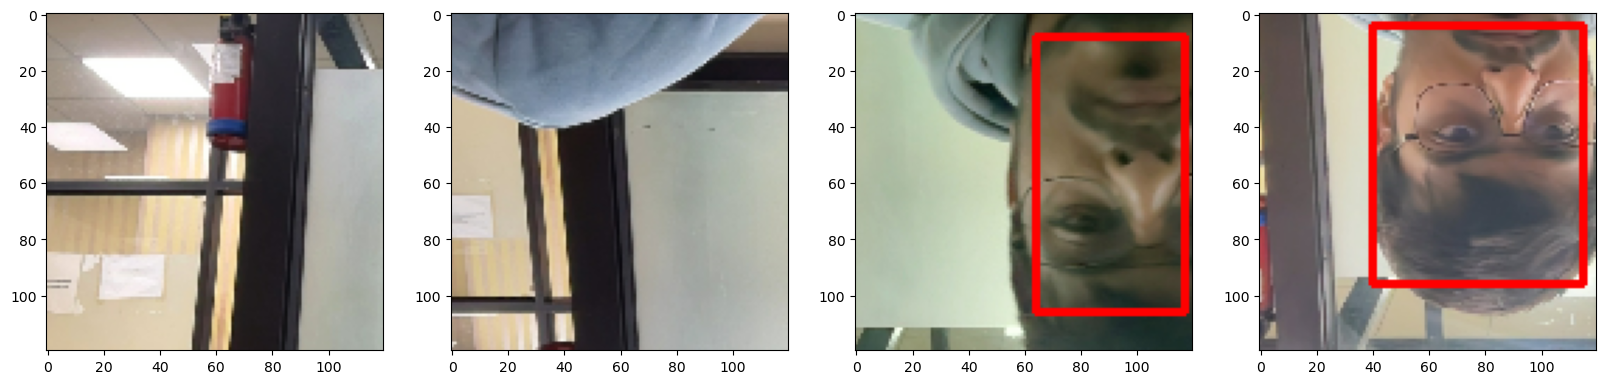

In [228]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    coppy = sample_image.copy()
    if yhat[0][idx] > 0.8:
        cv2.rectangle(coppy, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(coppy)

### 11.2 Save the Model

In [2]:
from tensorflow.keras.models import load_model

/Users/lakshyadujari/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [134]:
facetracker.save('/Users/lakshyadujari/Desktop/Projects/NIC_AI/FaceDetection/facetracker.keras')

In [3]:
facetracker = load_model('/Users/lakshyadujari/Desktop/Projects/NIC_AI/FaceDetection/facetracker.keras')

2024-02-19 16:53:03.339718: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-02-19 16:53:03.339752: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-19 16:53:03.339760: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-19 16:53:03.339841: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-19 16:53:03.340109: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### 11.3 Real Time Detection

In [7]:
import cv2
import tensorflow as tf
import numpy as np
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[100:1000, 100:1000,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.85:
        print(yhat[1]) 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [900,800]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [900,800]).astype(int)), 
                            (0,255,0), 1)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [900,800]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [900,800]).astype(int),
                                    [80,0])), 
                            (0,255,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [900,800]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 267ms/step


2024-02-19 16:53:55.471301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


[[0.80154186 0.1010573  0.98857284 0.9473899 ]]
1/1 [==============================] - 0s 15ms/step
[[0.80418575 0.10508403 0.9878578  0.9479166 ]]
1/1 [==============================] - 0s 15ms/step
[[0.81969696 0.10283721 0.98992735 0.9511947 ]]
1/1 [==============================] - 0s 15ms/step
[[0.82250106 0.10260266 0.99000424 0.9514625 ]]
1/1 [==============================] - 0s 16ms/step
[[0.82642835 0.10285332 0.9901631  0.95288146]]
1/1 [==============================] - 0s 16ms/step
[[0.82690245 0.10427336 0.9900787  0.9534065 ]]
1/1 [==============================] - 0s 16ms/step
[[0.82777166 0.10258874 0.9904113  0.95346785]]
1/1 [==============================] - 0s 15ms/step
[[0.8268141  0.10385141 0.99005145 0.9530096 ]]
1/1 [==============================] - 0s 16ms/step
[[0.8396223  0.10427428 0.99094945 0.9548758 ]]
1/1 [==============================] - 0s 14ms/step
[[0.8720972  0.10320901 0.9920421  0.9591512 ]]
1/1 [==============================] - 0s 16ms/step


In [138]:
cap = cv2.VideoCapture(1)
face_cap = cv2.CascadeClassifier('/Users/lakshyadujari/Desktop/Projects/NIC_AI/FaceDetection/haarcascade_frontalface_default.xml')
while True:
    ret, video = cap.read()
    col = cv2.cvtColor(video,cv2.COLOR_BGR2GRAY)
    faces = face_cap.detectMultiScale(col,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),flags = cv2.CASCADE_SCALE_IMAGE)
    for (x,y,w,h) in faces:
        cv2.rectangle(video,(x,y),(x+w,y+h),(0,255,0),2)
    cv2.imshow('Lakshya',video)
    if cv2.waitKey(10) == ord("a"):
        break
cap.release()

OpenCV: out device of bound (0-0): 1
OpenCV: camera failed to properly initialize!


error: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
